# Pytorch-花朵图像分类任务

### 1 导入包

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

### 2 数据读取与预处理

In [6]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

### 3 制作数据源

##### · data_transforms中指定了所有图像预处理操作
##### · ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存储同一类别图片，文件夹的名字为分类的名字

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256), # 大部分网络都是256*256的图像大小，因此需要把训练数据 Resize 一下
        transforms.RandomRotation(45), # 随机旋转，-45度到45度
        transforms.CenterCrop(224), # 从中心裁剪 按照网络的要求，需要输入的图像的大小是224*224的，因此就在图像中心裁剪出一个224*224的框，也可以进行随机裁剪
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025), # 概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 因为到时候是用别人已经预训练好的网络来实现，因此这里的Normalize是要使图像符合人家标准
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### 4 加载数据文件夹并读取标签文件

In [8]:
# 加载数据文件夹
batchsize = 8

train_datasets = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
test_datasets = datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])

train_dataloader = DataLoader(dataset=train_datasets, batch_size = batchsize, shuffle=True)
test_dataloader = DataLoader(dataset=test_datasets, batch_size=batchsize, shuffle=True)
dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader
}

train_size = len(train_datasets)
test_size = len(test_datasets)

class_names = train_datasets.classes

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
# class_names = image_datasets['train'].classes

# 读取标签文件
with open('flower_to_name.json', 'r') as f:
    flower_to_name = json.load(f)
flower_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### 5 展示一下数据

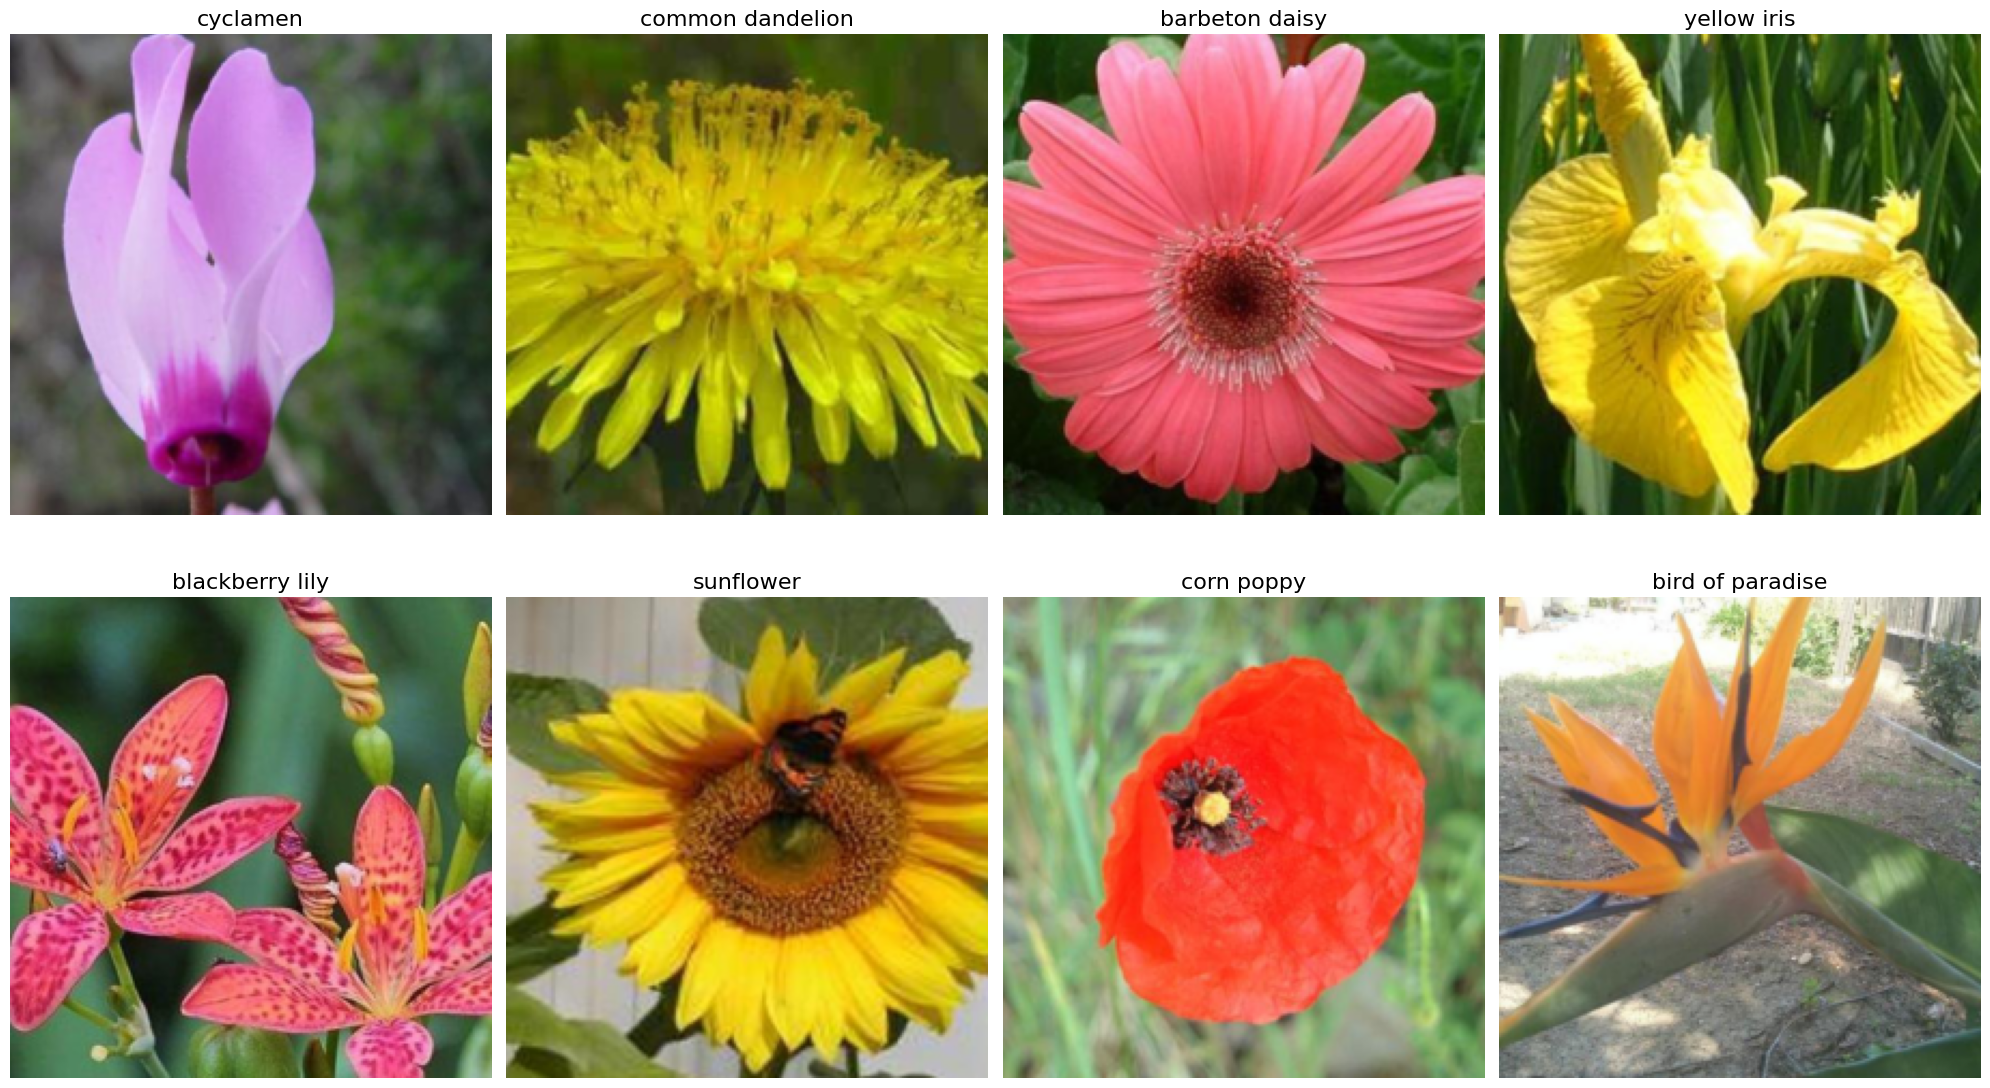

In [56]:
def data_display(tensor):
    image = tensor.to('cpu').clone().detach() # 本来已经成了tensor类型的数据，但是要展示的话得恢复成以前的数据类型
    image = image.numpy().squeeze()
    # tensor类型是（H，W，C），但是需要展示的数据类型是（C，H，W）
    # 因此 transpose 这个是把 1号位->2号位，2号位->0号位，0号位->1号位
    image = image.transpose(1,2,0) 
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) # 对图像进行截断操作，使数值保持在 0-1 之间
    
    return image

fig = plt.figure(figsize=(20, 12)) # 创建一个高20宽20的画布
columns = 4
rows = 2
data_iter = iter(test_dataloader) # 将test_dataloader转换为迭代器
inputs, classes = next(data_iter) # 从迭代器中获取下一个批次的数据

for i in range(columns*rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(flower_to_name[str(int(class_names[classes[i]]))], fontsize=16)
    ax.axis('off')  # Turn off axis labels and ticks
    plt.imshow(data_display(inputs[i]))

plt.tight_layout()
plt.show()

### 6 加载models中提供的模型，并且直接用训练好的权重当作初始化参数

In [10]:
model_name = 'resnet' #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
# 迁移学习，是否用训练好的参数
feature_extract = True

# 用mps训练
device = torch.device('mps')

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 把选定的这些参数不改变 这里就是把梯度冻住
            
model_select = models.resnet152()
'''
    现在已经把resnet152模型拿到手了，打印resnet152模型后发现，最后的一个全连接层，in_features是2048，out_features=1000，说明最后是一个1000分类的任务
    但是我们现在要做的这个任务是102分类，因此后面调参时要把1000改成102
'''
model_select

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 7 初始化自己的模型

In [33]:
def my_model(model_name, num_classes, feature_extract, use_pretrained_or_not=True):
    
    # 选择适合的模型
    model_fit = None
    input_size = 0
    
    if model_name == 'resnet':
        model_fit = models.resnet152()
        set_parameter_requires_grad(model_fit, feature_extract)
        # 准备更改参数
        former_in_features = model_fit.fc.in_features # 取出全连接层FC的输入特征
        now_in_features = 102 # 新的输出特征
        model_fit.fc = nn.Sequential( # 重写FC层
            nn.Linear(former_in_features, now_in_features), # 重写FC层
            nn.LogSoftmax(dim=1),
        )
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_fit, input_size

### 8 设置哪些层需要训练

In [34]:
# 获取适应于此项目的模型
model_fit, input_size = my_model(model_name, 102, feature_extract, use_pretrained_or_not=True)
model_fit = model_fit.to(device)
file_name = 'checkpoint_new.pth'

# 是否训练所有层
params_to_update = model_fit.parameters()
print("parameters to learn:")
if feature_extract: # 采用已经训练好的参数（前面的层）
    params_to_update=[]
    print("\tfeature_extract is True:")
    for name, param in model_fit.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t\t", name)
else:
    print("\tfeature_extract is False:")
    for name, param in model_fit.named_parameters():
        if param.requires_grad == True:
            print("\t\t", name)

# 再看一下这个模型
model_fit

parameters to learn:
	feature_extract is True:
		 fc.0.weight
		 fc.0.bias


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 9 优化器设置

In [13]:
learning_rate = 1e-2
optim_fit = optim.Adam(params_to_update, lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=optim_fit, step_size=5, gamma=0.1) # 学习率每5个epoch衰减成原来的1/10
# 由于最后一层已经LogSoftMax()了，所以不能用交叉熵nn.CrossEntropyLoss()计算，nn.CrossEntropyLoss()相当于LogSoftmax()和nn.NLLLoss()整合
loss_func = nn.NLLLoss()

### 10 准备训练模块

In [153]:
def train_model(model, dataloaders, loss_function, optimizer, epochs, filename=file_name):
    
    since = time.time()
    best_accuracy = 0 # 计算每个epoch的准确率
    
    model.to(device)
    
    train_acc_history=[]
    test_acc_history=[]
    train_losses=[]
    test_losses=[]
    LRs=[optimizer.param_groups[0]['lr']]
    
    # 存储准确率高的模型
    best_models = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print(f"第{epoch+1}/{epochs}次训练：")
        print('-'*10)
        
        # 训练和验证
        for phrase in ['train', 'test']:
            if phrase == 'train':
                model.train() # 训练
            else:
                model.eval() # 验证
            
            running_loss = 0.0
            running_corrects = 0
            
            # 遍历取数据
            for inputs, labels in dataloaders[phrase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phrase == 'train'):
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                
                    
                    # 训练阶段更新权重
                    if phrase == 'train':
                        loss.backward()
                        optimizer.step()
                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phrase].dataset)
            epoch_accuracy = running_corrects.float() / len(dataloaders[phrase].dataset)
            
            time_consume = time.time() - since
            print(f"耗时{time_consume//60}min {time_consume%60}s")
            print(f"{phrase} Loss:{epoch_loss:.4f} Accuracy:{epoch_accuracy:.4f}")
            
            
            # 得到最好的那次模型
            if phrase == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_models = copy.deepcopy(model.state_dict())
                # 用字典把下面这些关键属性存下来
                state = {
                    'state_dict': model.state_dict(),
                    'best_accuracy': best_accuracy,
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(state, filename)
            # 添加历史记录
            if phrase == 'test':
                test_acc_history.append(epoch_accuracy)
                test_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phrase == 'train':
                train_acc_history.append(epoch_accuracy)
                train_losses.append(epoch_loss)
        # end for-loop
        
        print(f"Optimizer learning rate: {optimizer.param_groups[0]['lr']:.7f}")
        LRs.append(optimizer.param_groups[0]['lr'])
        print('--------------------------------------------------------------------')
        # end this epoch
    
    total_time = time.time() - since
    print(f'Training complete, total time is: {total_time//60}min {total_time/60}s')
    print(f'Best val Accuracy is: {best_accuracy:.4f}')
    
    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_models)
    
    return model, test_acc_history, train_acc_history, test_losses, train_losses, LRs

In [16]:
# 分开写
# 1、训练数据
def train_epoch(model, dataloader, loss_function, optimizer):
    model.train() # 将模型设置为训练模式
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad() # 清零优化器梯度以准备进行反向传播

        outputs = model(inputs) # 传入模型进行前向传播
        loss = loss_function(outputs, targets) # 计算损失值
        _, predicts = torch.max(outputs, 1) # 获取预测类别
        
        loss.backward()
        optimizer.step()
        
        # 计算损失
        """
            这个计算的是每个批次的损失值，即64张图的损失值之和
            inputs.size(0) 是第一个维度的值，即批次大小
        """
        running_loss += loss.item() * inputs.size(0) 
        # 统计对的个数
        running_corrects += torch.sum(predicts == targets.data)
    # 计算损失和准确率
    train_epoch_loss = running_loss / len(dataloader.dataset)
    train_epoch_accuracy = running_corrects / len(dataloader.dataset)
    
    """
        训练数据时特有，调整学习率
    """
    scheduler.step(train_epoch_loss)
    
    return train_epoch_loss, train_epoch_accuracy

# 2、测试数据
def test_epoch(model, dataloader, loss_function, optimizer, filename=file_name):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_accuracy = 0.0
    
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = loss_function(outputs, targets)
        _, predicts = torch.max(outputs, 1)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predicts == targets)
    
    test_epoch_loss = running_loss / len(dataloader.dataset)
    test_epoch_accuracy = running_corrects / len(dataloader.dataset)
    
    """
        测试集独有的，保存数据部分
        得到最好的那次模型
    """
    if test_epoch_accuracy > best_accuracy:
        best_accuracy = test_epoch_accuracy
        best_models = copy.deepcopy(model.state_dict())
        state={
            "state_dict": model.state_dict(),
            "best_accuracy": best_accuracy,
            "optimizer": optimizer.state_dict(),
        }
        torch.save(state, f"{filename}")
    
    return test_epoch_loss, test_epoch_accuracy, best_accuracy

# 3、总训练函数
def train_model_divide(model, loss_function, optimizer, epochs, filename=file_name):
    since = time.time()
    model = model.to(device)
    
    train_accuracy_history=[]
    test_accuracy_history=[]
    train_losses=[]
    test_losses=[]
    LRs=[optimizer.param_groups[0]['lr']] # optimizer是优化器，param_groups是参数列表，0是第一个参数组，lr指定获取第一个参数组的lr项
    
    best_models = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print(f"第{epoch+1}/{epochs}次训练")
        print(f"-"*20)
        
        # 传入训练数据和测试数据 即调用训练函数和测试函数
        train_epoch_loss, train_epoch_accuracy = train_epoch(model, train_dataloader, loss_function, optimizer)
        test_epoch_loss, test_epoch_accuracy, best_accuracy = test_epoch(model, test_dataloader, loss_function, optimizer)
        
        # 计算时间
        epoch_consume_time = time.time() - since
        print(f"本次训练耗时：{epoch_consume_time//60} min {epoch_consume_time%60} s ，训练效果如下：")
        print(f"\t train_accuracy:{train_epoch_accuracy:.4f}, train_loss:{train_epoch_loss:.4f}")
        print(f"\t test_accuracy:{test_epoch_accuracy:.4f}, test_loss:{test_epoch_loss:.4f}")  
        
        # 将这些数据添加到数组中
        train_losses.append(train_epoch_loss)
        train_accuracy_history.append(train_epoch_accuracy)
        test_losses.append(test_epoch_loss)
        test_accuracy_history.append(test_epoch_accuracy)
        LRs.append(optimizer.param_groups[0]['lr'])
        
        print(f"Optimizer learning rate: {optimizer.param_groups[0]['lr']:.7f}")
        print()
        
    # 迭代完成
    time_total_consume = time.time() - since
    print(f"-"*30)
    print(f"Train complete in {time_total_consume//60} min {time_total_consume%60} s ")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    # 迭代完成后用最好的一次当做模型的最终的结果
    model.load_state_dict(best_models)
    
    return model, train_losses, train_accuracy_history, test_losses, test_accuracy_history, LRs

### 11 开始炼丹

In [17]:
num_epochs=5
# model_fit, test_acc_history, train_acc_history, test_losses, train_losses, LRs = train_model(
#     model=model_fit, dataloaders=dataloaders, loss_function=loss_func, optimizer=optim_fit, epochs=num_epochs
# )
my_model, train_losses, train_accuracy_history, test_losses, test_accuracy_history, LRs = train_model_divide(
    model=model_fit,
    loss_function=loss_func,
    optimizer=optim_fit,
    epochs = num_epochs
)

第1/5次训练
--------------------
本次训练耗时：2.0 min 6.85331392288208 s ，训练效果如下：
	 train_accuracy:0.8055, train_loss:1.2941
	 test_accuracy:0.6064, test_loss:7.6713
Optimizer learning rate: 0.0100000

第2/5次训练
--------------------
本次训练耗时：4.0 min 12.750571966171265 s ，训练效果如下：
	 train_accuracy:0.5721, train_loss:8.1694
	 test_accuracy:0.8875, test_loss:1.4475
Optimizer learning rate: 0.0010000

第3/5次训练
--------------------
本次训练耗时：6.0 min 17.42436981201172 s ，训练效果如下：
	 train_accuracy:0.8423, train_loss:1.6592
	 test_accuracy:0.8325, test_loss:2.5405
Optimizer learning rate: 0.0100000

第4/5次训练
--------------------
本次训练耗时：8.0 min 21.41840410232544 s ，训练效果如下：
	 train_accuracy:0.6472, train_loss:7.4333
	 test_accuracy:0.8790, test_loss:2.1434
Optimizer learning rate: 0.0010000

第5/5次训练
--------------------
本次训练耗时：10.0 min 26.687976837158203 s ，训练效果如下：
	 train_accuracy:0.8503, train_loss:1.9430
	 test_accuracy:0.8545, test_loss:4.2171
Optimizer learning rate: 0.0100000

------------------------------
Tr

### 12 再继续训练所有层
· 因为刚刚只训练了最后一个FC层，所以效果可能不是很好；因此后续可以进行训练所有层

In [18]:
for param in model_fit.parameters(): # 取出模型中的所有参数
    param.requires_grad = True # 把所有参数是否训练的选项调为 True

# 再继续训练所有参数，学习率调小一点
learning_rate = 1e-4
optimizer = optim.Adam(params_to_update, lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optim_fit, step_size=5, gamma=0.1)

# 损失函数
loss_func = nn.NLLLoss()

In [20]:
# 再次训练的时候，是在刚刚训练完成的基础上进行训练，因此需要load刚刚训练完成的checkpoint
checkpoint = torch.load("checkpoint_new.pth")
best_accuracy = checkpoint['best_accuracy']
model_fit.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [26]:
num_epochs=5
# model_fit, test_acc_history, train_acc_history, test_losses, train_losses, LRs = train_model(
#     model=model_fit, dataloaders=dataloaders, loss_function=loss_func, optimizer=optim_fit, epochs=num_epochs
# )
my_model, train_losses, train_accuracy_history, test_losses, test_accuracy_history, LRs = train_model_divide(
    model=model_fit,
    loss_function=loss_func,
    optimizer=optim_fit,
    epochs = num_epochs
)

第1/5次训练
--------------------


KeyboardInterrupt: 

### 13 加载训练好的模型

In [36]:
model_fit, input_size = my_model(model_name, 102, feature_extract)

# 采用gpu
model_fit = model_fit.to(device)

# 保存
file_name = 'checkpoint_new.pth'

# 加载模型
checkpoint = torch.load(file_name)
best_accuracy = checkpoint['best_accuracy']
model_fit.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### 14 测试数据预处理
##### · 测试数据的处理方法需要和训练数据一模一样
##### · crop操作的目的是保证输入的大小是一样的
##### · 标准化操作也是必须的，用跟训练数据相同的mean和std，但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化 
##### · 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换

In [37]:
# 处理图片
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))
    
    return img

<Axes: >

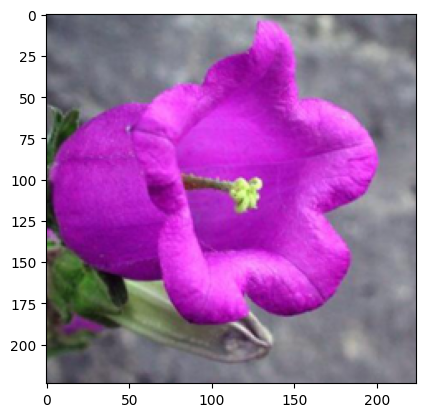

In [38]:
# 展示一下
def img_show(image, ax=None, title=None):
    if ax == None:
        fig, ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))
    
    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

image_path = 'image_06621.jpg'
img = process_image(image_path)
img_show(img)

In [39]:
# 从test数据集中得到一个batch的测试数据
dataiter = iter(test_dataloader)
images, targets = next(dataiter)

model_fit.eval()

output = model_fit(images.to(device)) # output 表示这个batch的每一张图片对于102个类别的概率 是一个 8*12 的矩阵

output.shape

torch.Size([8, 102])

### 15 得到概率最大的那个数据

In [42]:
_, predicts = torch.max(output, 1)
preds = np.squeeze(predicts.cpu().numpy())
preds

array([64, 21, 96, 93, 17, 51, 96, 89])

### 16 展示预测结果

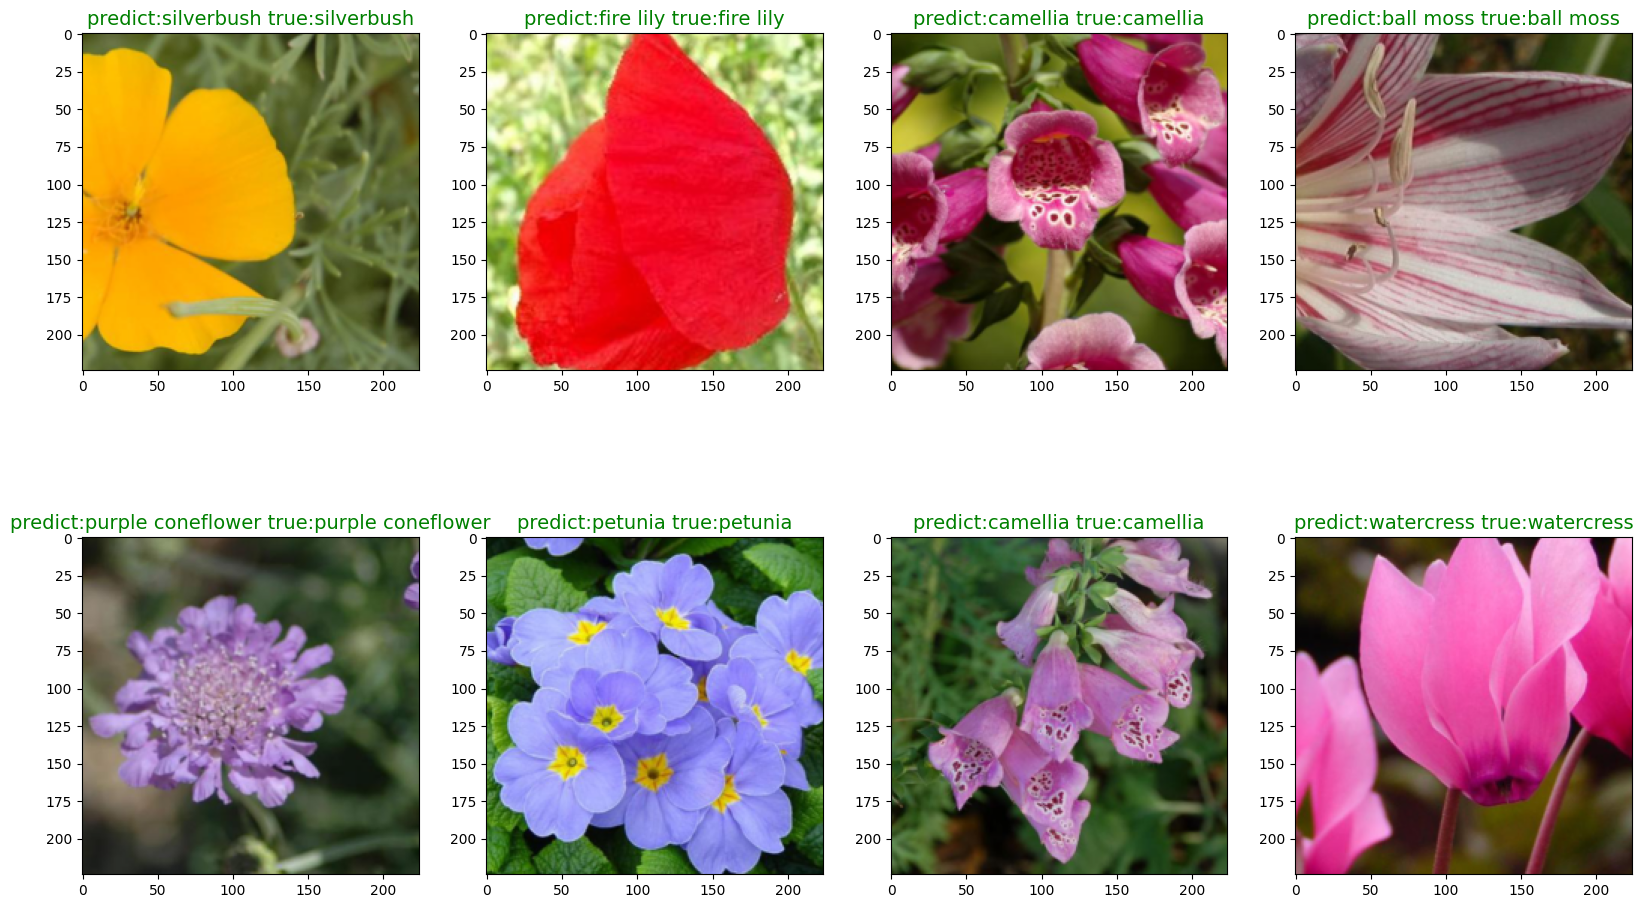

In [60]:
fig=plt.figure(figsize=(20, 12))
columns =4
rows = 2

for i in range (columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    plt.imshow(data_display(images[i]))
    ax.set_title(
        f"predict:{flower_to_name[str(predicts[i].item())]} true:{flower_to_name[str(targets[i].item())]}",
        color=(
            "green" if flower_to_name[str(predicts[i].item())]==flower_to_name[str(targets[i].item())]
        else "red"),
        fontsize = 14
    )
plt.show()